In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "../weights/edge_sam.pth"
model_type = "edge_sam"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CE5C0200YJFM001GP-5000XB40C40-mosaic-scaled

In [4]:
image = cv2.imread('/home/pumbaa/Documents/OriginDataset/Moon/CE5C0200YJFM001GP-5000XB40C40-mosaic-scaled/resample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

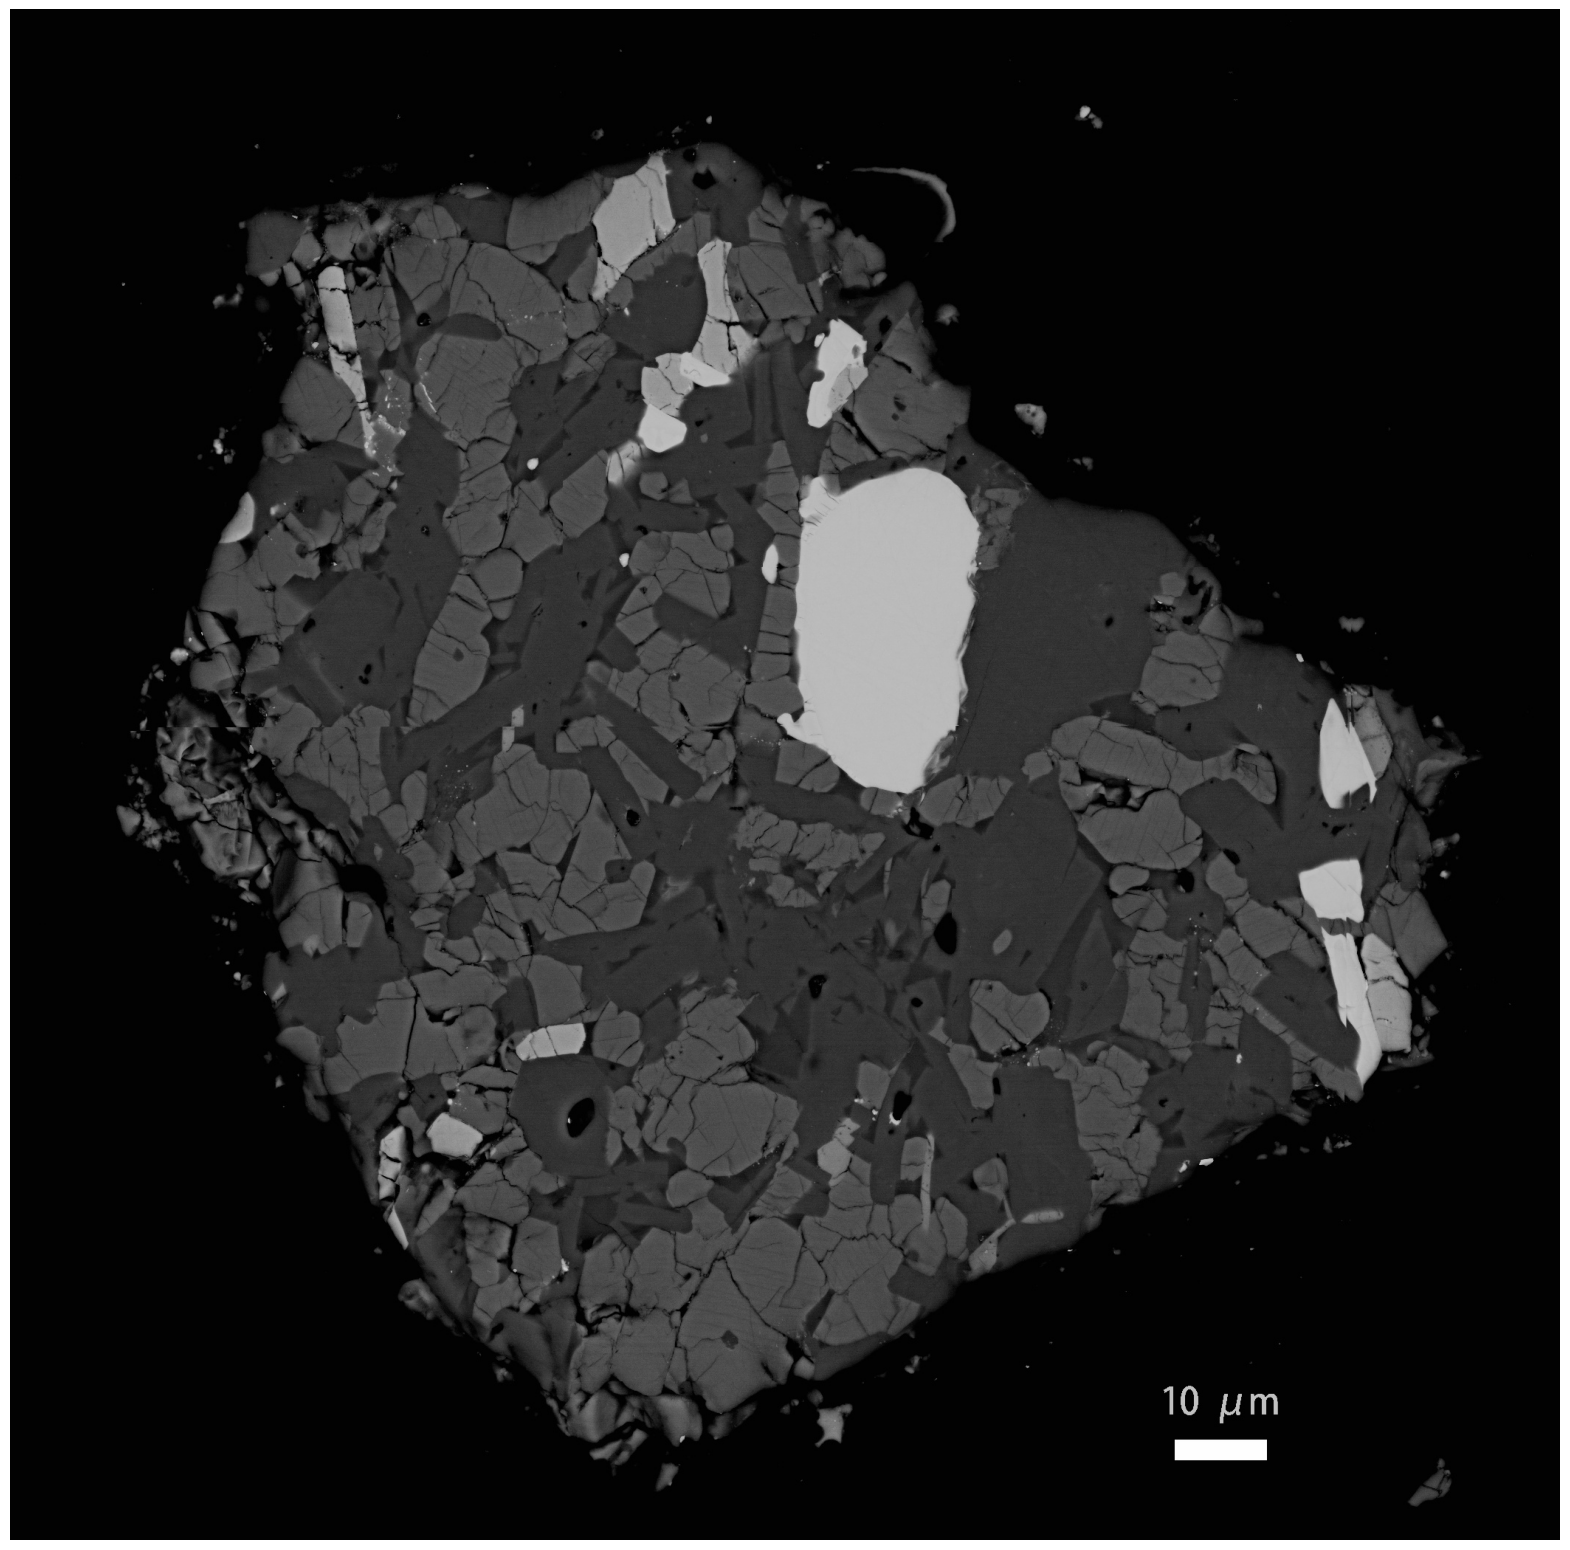

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

To generate masks, just run `generate` on an image.

In [6]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [7]:
print(len(masks))
print(masks[0].keys())

113
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

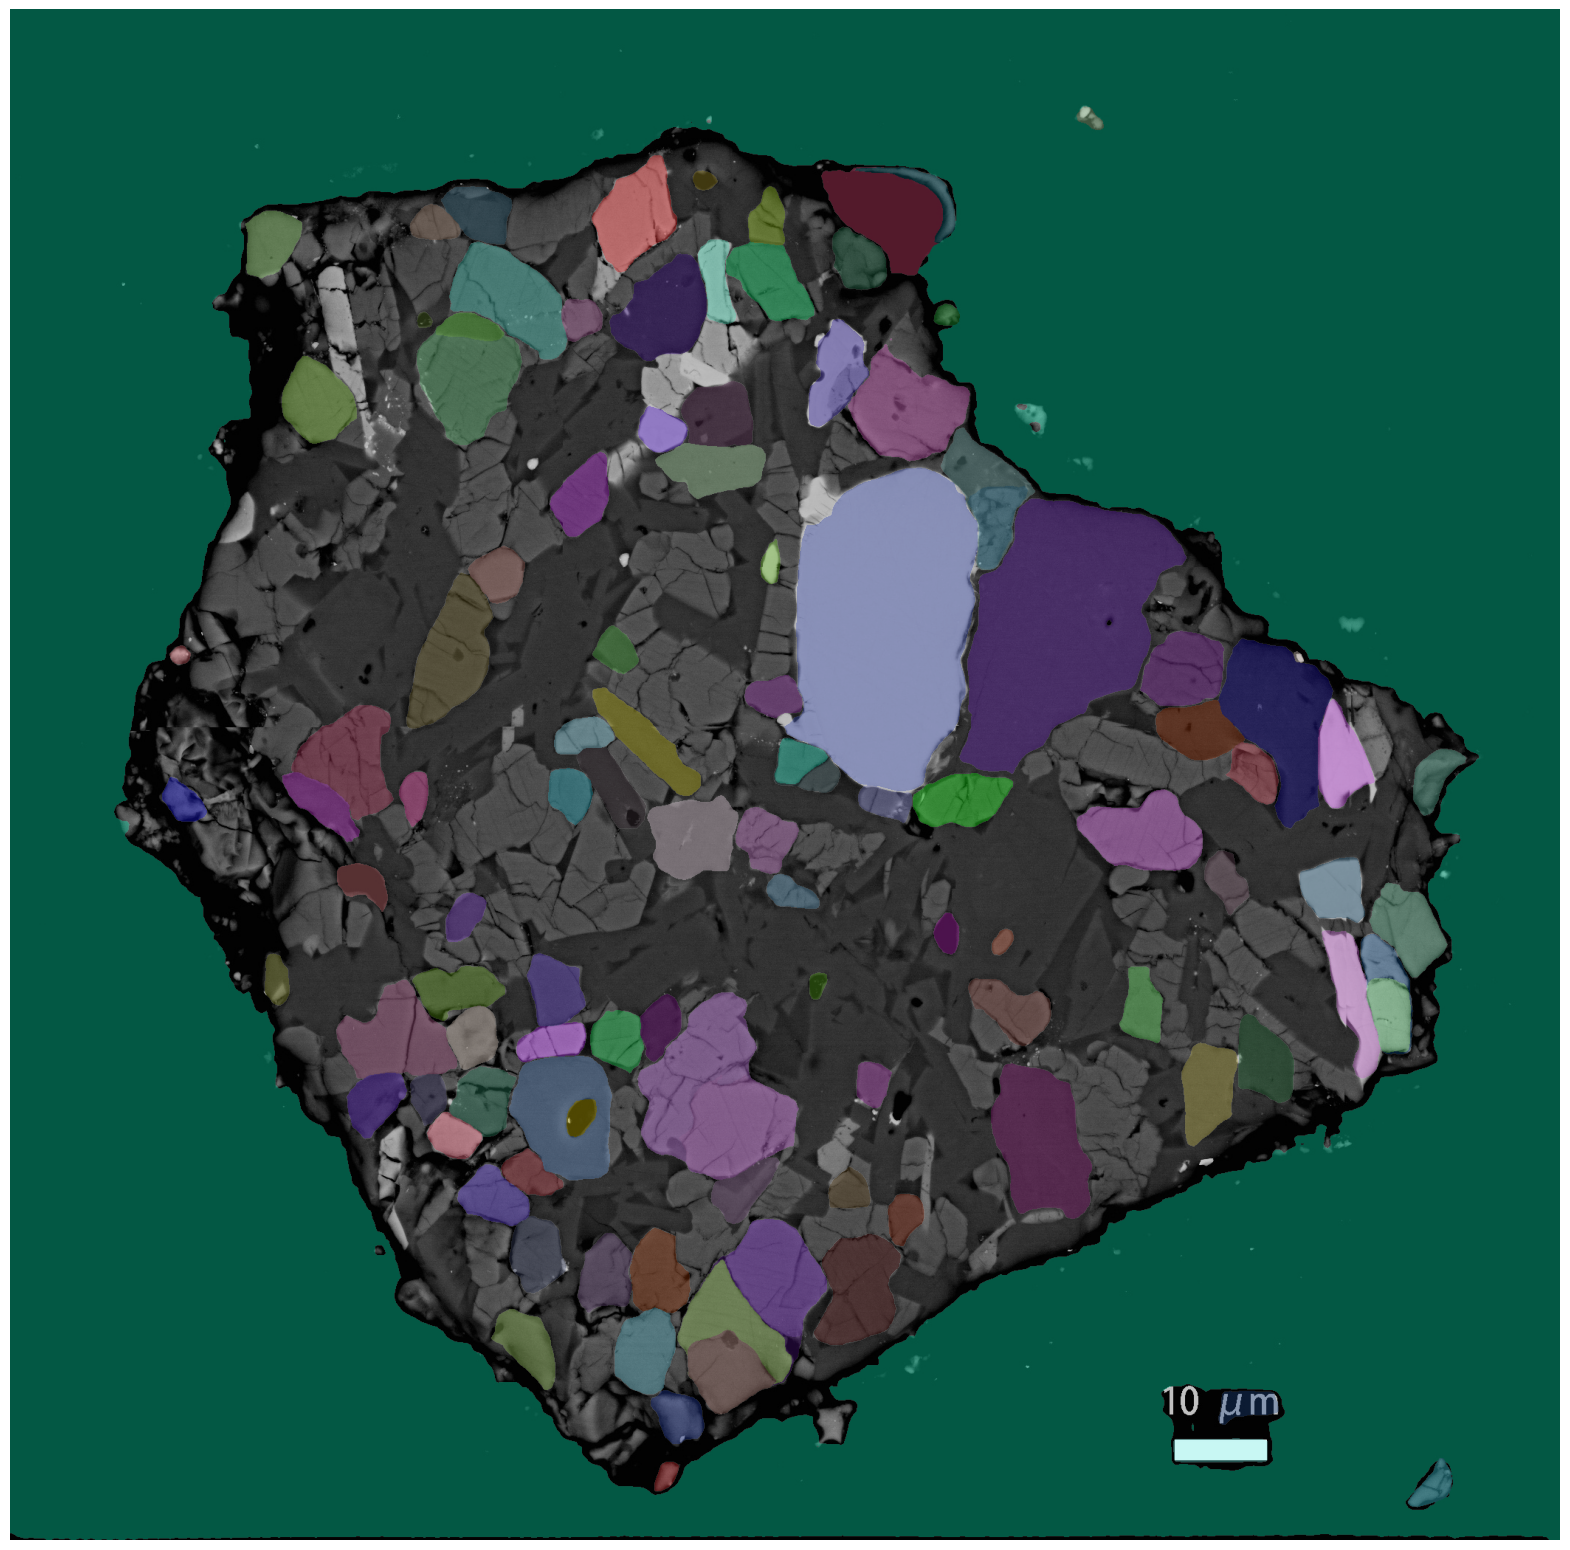

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [14]:
torch.cuda.empty_cache() #清空显存占用

In [10]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=256,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [11]:
masks2 = mask_generator_2.generate(image)

In [13]:
len(masks2)

1237

In [16]:
masks2[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 878,
 'bbox': [1037, 752, 32, 35],
 'predicted_iou': 0.9677419066429138,
 'point_coords': [[1047.75, 774.3233333333333]],
 'stability_score': 0.9290392994880676,
 'crop_box': [697, 0, 1403, 1391]}

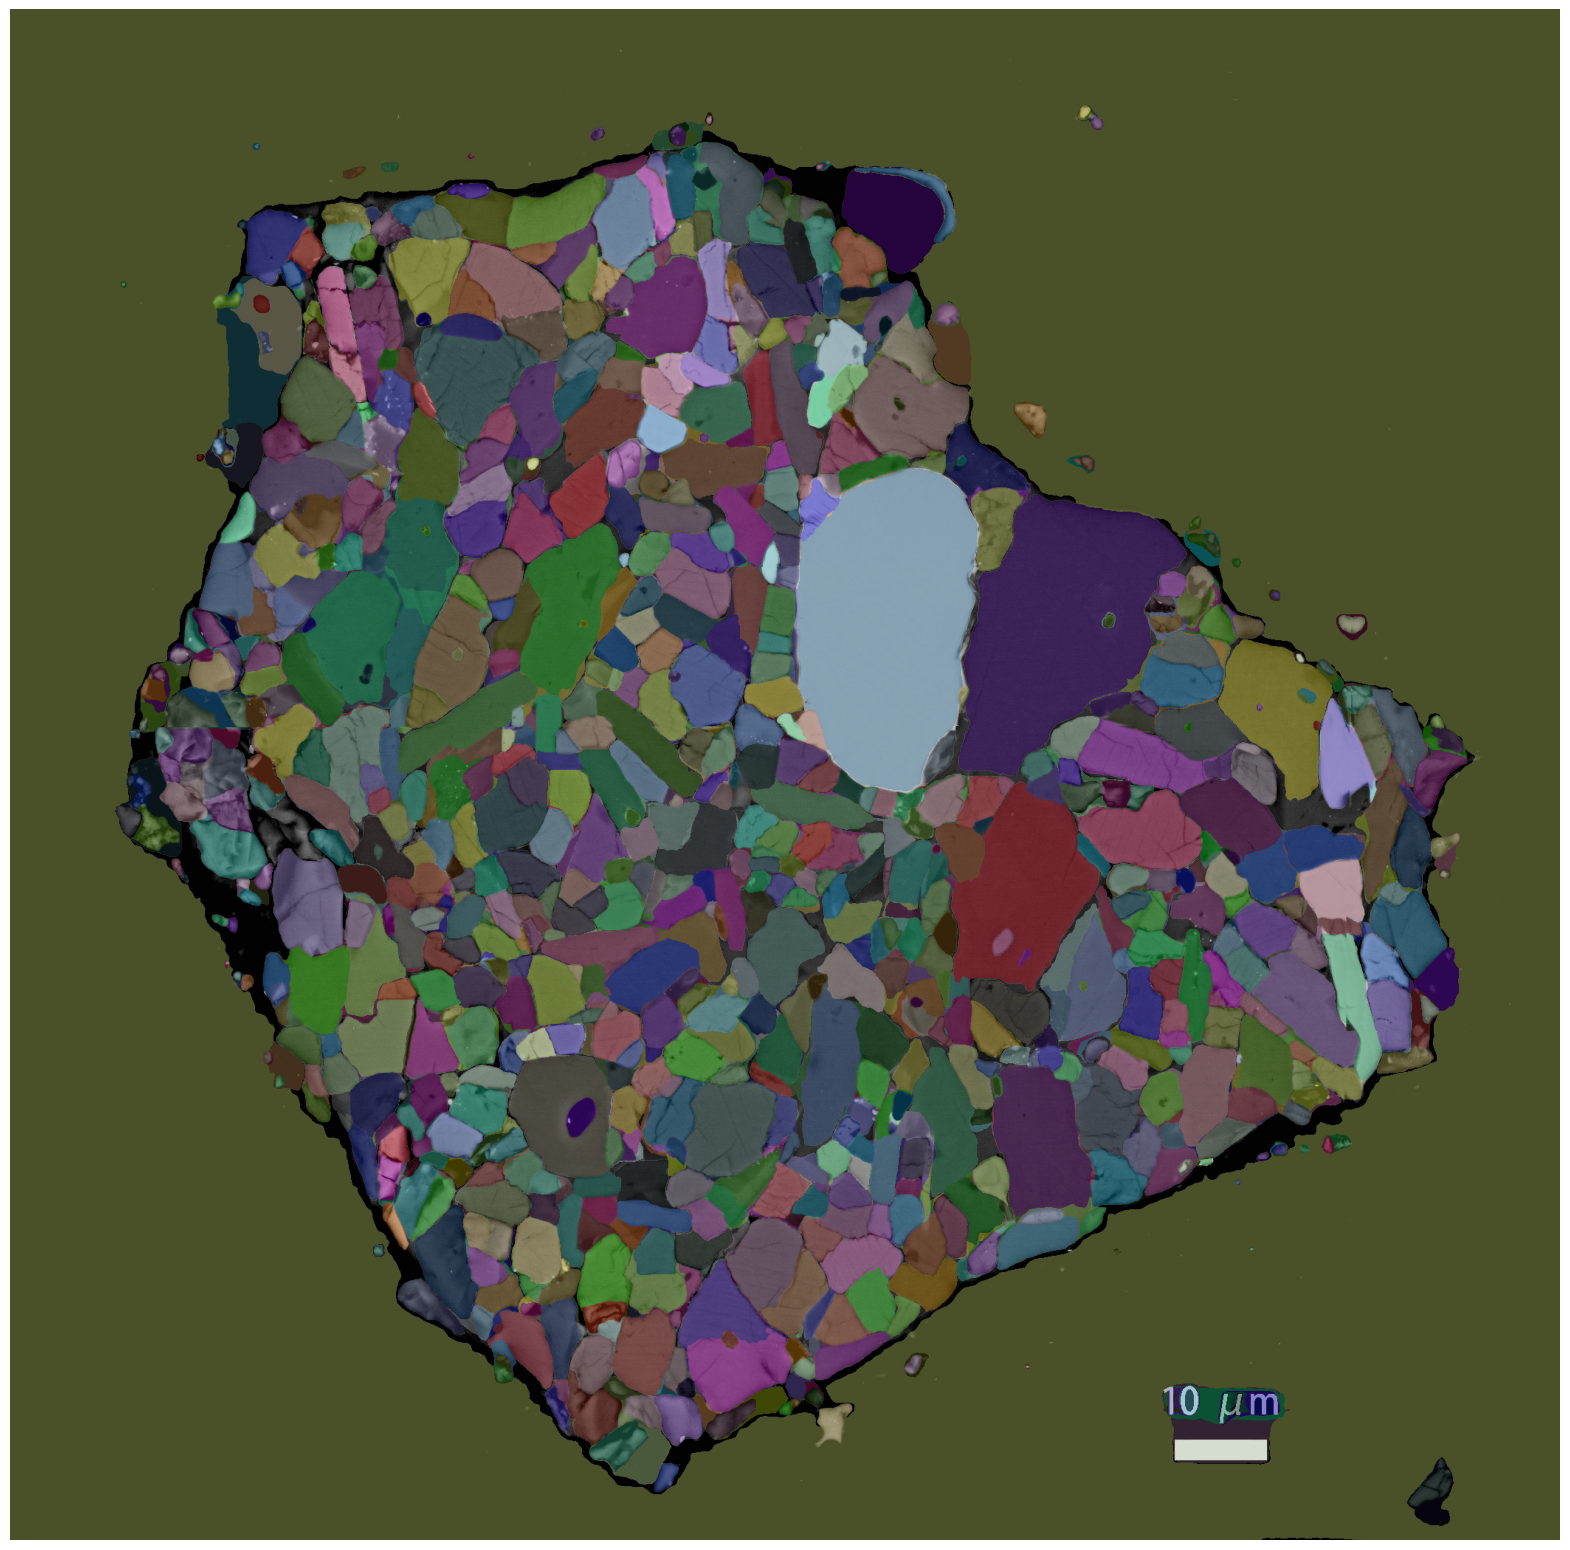

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

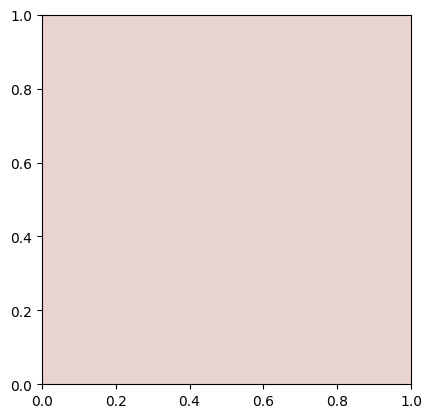

In [22]:
sorted_anns = sorted(masks2, key=(lambda x: x['area']), reverse=True)
ax = plt.gca()
ax.set_autoscale_on(False)

img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
img[:,:,3] = 0
for ann in sorted_anns:
    m = ann['segmentation']
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    img[m] = color_mask
ax.imshow(img)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_anns(anns, original_shape, save_tiff_path=None):
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Use the original image shape for creating the mask
    img = np.ones((original_shape[0], original_shape[1], 4), dtype=np.float32)
    img[:,:,3] = 0
    
    for ann in sorted_anns:
        # Upsample the segmentation mask to the original image shape
        m_upsampled = cv2.resize(ann['segmentation'].astype(np.uint8), (original_shape[1], original_shape[0]))

        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m_upsampled > 0] = color_mask

    if save_tiff_path:
        # Save the mask as a TIFF file
        img_for_tiff = (img[:,:,0:3] * 255).astype(np.uint8)  # Convert RGB values to uint8
        tiff_image = Image.fromarray(img_for_tiff)
        tiff_image.save(save_tiff_path, format='TIFF')

    plt.show()

# 示例用法，假设原始图像大小为 (original_height, original_width)
show_anns(masks2, original_shape=(56562, 59245), save_tiff_path='/home/pumbaa/Documents/OriginDataset/Moon/output/output_mask.tiff')

In [28]:
sorted_anns[0]['segmentation'].shape

(2074, 2100)

In [33]:
img.shape

(2074, 2100, 4)

# CE5C0200YJFM001GP-5000X-B32.5C32.5-mosaic-scaled

锆石（Zr）：灰度区间 [205,225]，峰值区间219-221

钛铁矿（IIm）:灰度区间[190,205]，峰值区间：197-200

白磷钙矿(Merr):灰度区间 [160,180]，峰值区间：151-154

辉石（pyx）:灰度区间[100,120]，峰值区间：110-117

斜长石（Pl）:灰度区间[55,75]，峰值区间：61-70

含钾玻璃（K-glass）: [30,50].峰值区间：[30,50]

In [23]:
image = cv2.imread('/home/pumbaa/Documents/OriginDataset/Moon/CE5C0200YJFM001GP-5000X-B32*5C32*5-mosaic-scaled/resample.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.medianBlur(image, 3)

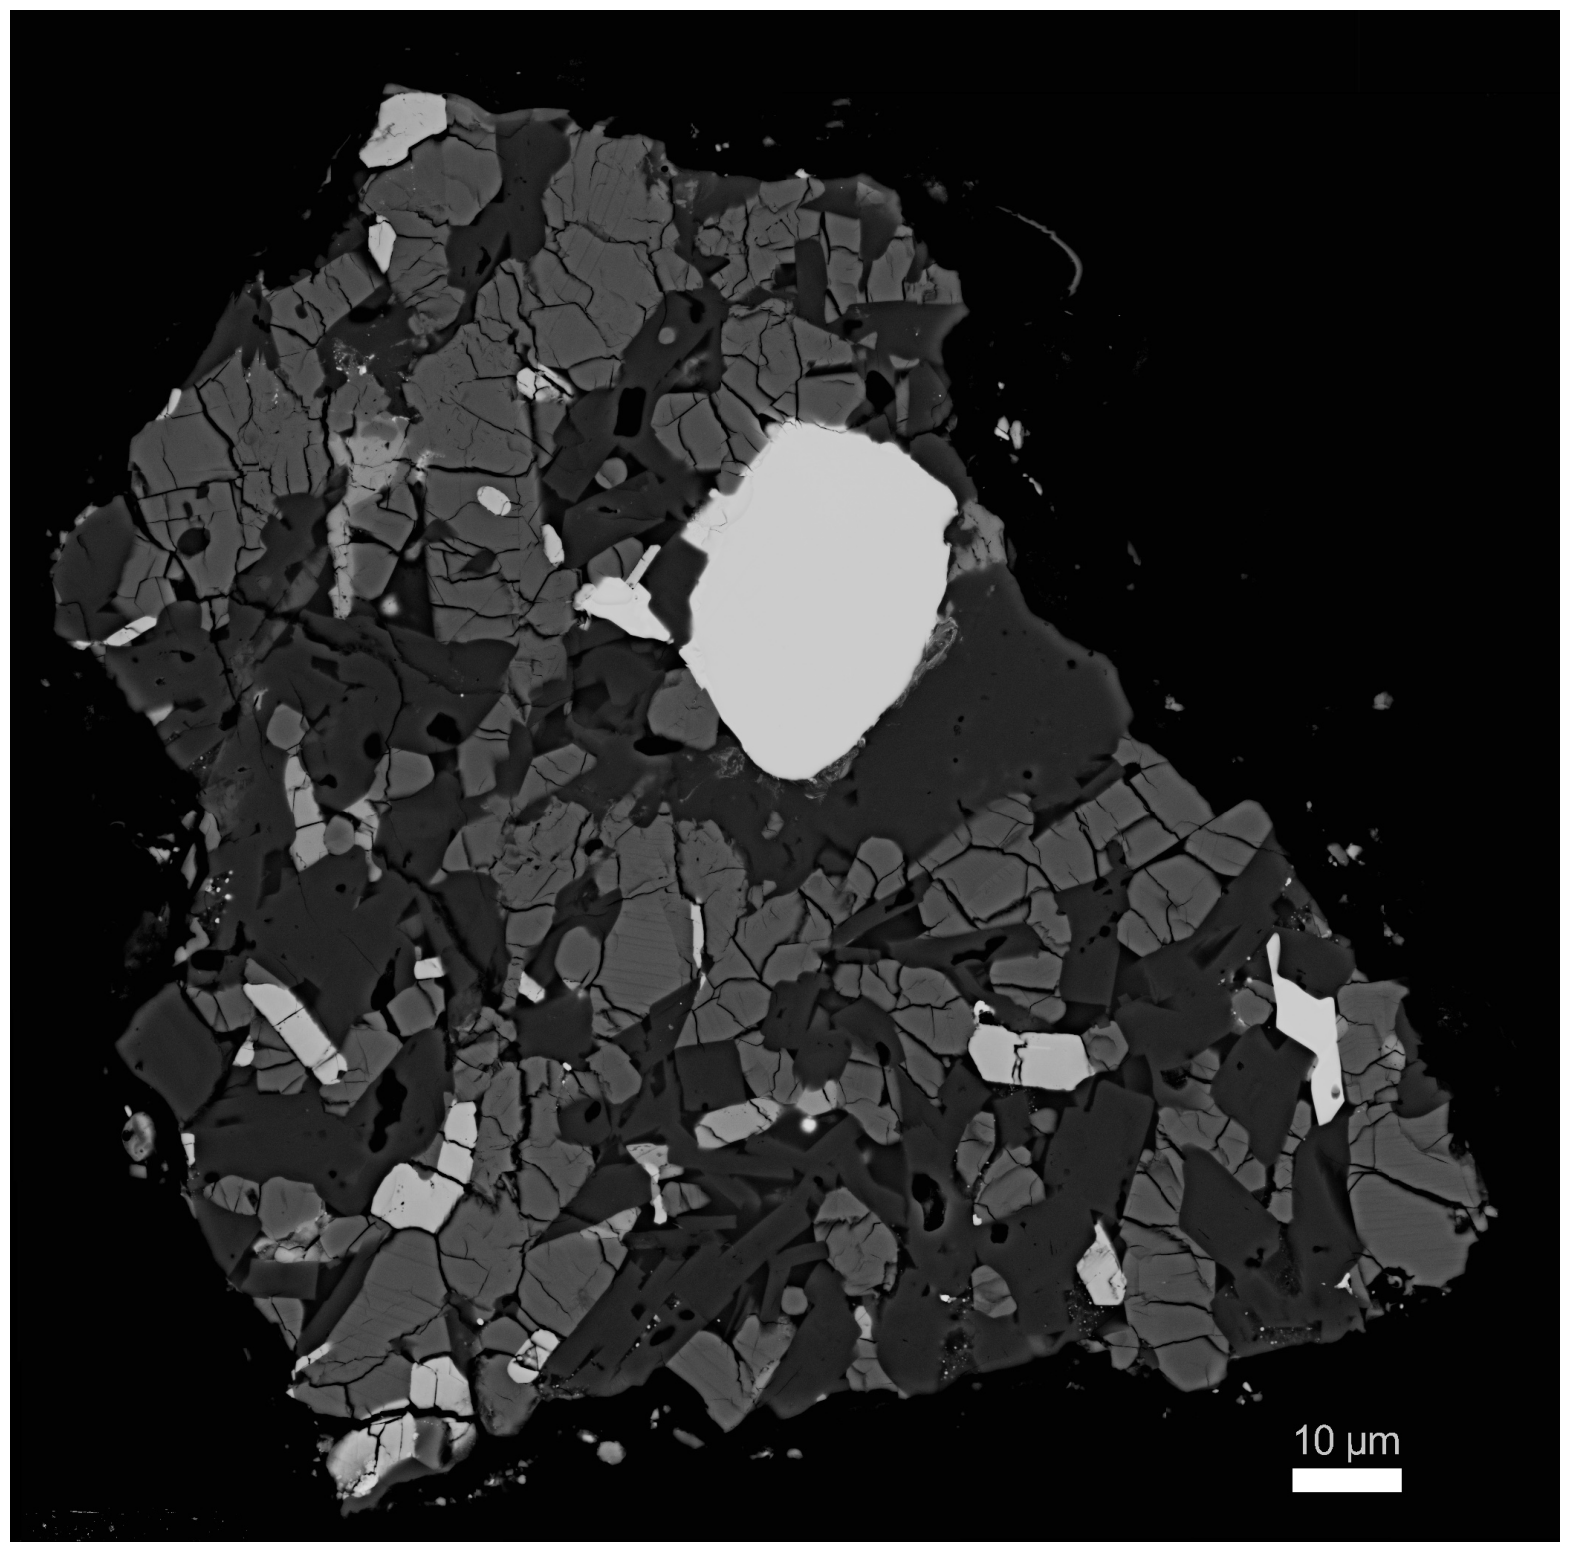

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

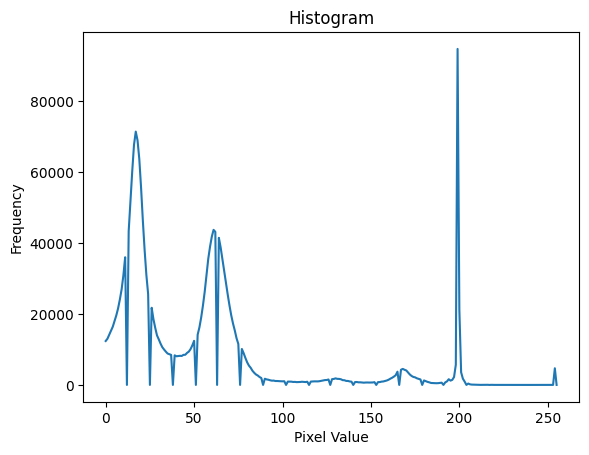

In [24]:
# 计算直方图
hist = cv2.calcHist([image], [0], None, [256], [20, 256])

# 绘制直方图
plt.plot(hist)
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

灰度值 0: [29373.] 像素
灰度值 1: [30225.] 像素
灰度值 2: [1937223.] 像素
灰度值 3: [37036.] 像素
灰度值 4: [20009.] 像素
灰度值 5: [13579.] 像素
灰度值 6: [10720.] 像素
灰度值 7: [9505.] 像素
灰度值 8: [9242.] 像素
灰度值 9: [8834.] 像素
灰度值 10: [8942.] 像素
灰度值 11: [9147.] 像素
灰度值 12: [9225.] 像素
灰度值 13: [9399.] 像素
灰度值 14: [9630.] 像素
灰度值 15: [9821.] 像素
灰度值 16: [10306.] 像素
灰度值 17: [10677.] 像素
灰度值 18: [10920.] 像素
灰度值 19: [11698.] 像素
灰度值 20: [12383.] 像素
灰度值 21: [13034.] 像素
灰度值 22: [14184.] 像素
灰度值 23: [15280.] 像素
灰度值 24: [16411.] 像素
灰度值 25: [17976.] 像素
灰度值 26: [19619.] 像素
灰度值 27: [21582.] 像素
灰度值 28: [24070.] 像素
灰度值 29: [26929.] 像素
灰度值 30: [30893.] 像素
灰度值 31: [36003.] 像素
灰度值 32: [43384.] 像素
灰度值 33: [51781.] 像素
灰度值 34: [60205.] 像素
灰度值 35: [67683.] 像素
灰度值 36: [71437.] 像素
灰度值 37: [68995.] 像素
灰度值 38: [63717.] 像素
灰度值 39: [55647.] 像素
灰度值 40: [46426.] 像素
灰度值 41: [38108.] 像素
灰度值 42: [31019.] 像素
灰度值 43: [25611.] 像素
灰度值 44: [21754.] 像素
灰度值 45: [18539.] 像素
灰度值 46: [16123.] 像素
灰度值 47: [13981.] 像素
灰度值 48: [12870.] 像素
灰度值 49: [11672.] 像素
灰度值 50: [10649.] 

/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pumbaa/anaconda3/envs/LLM/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK

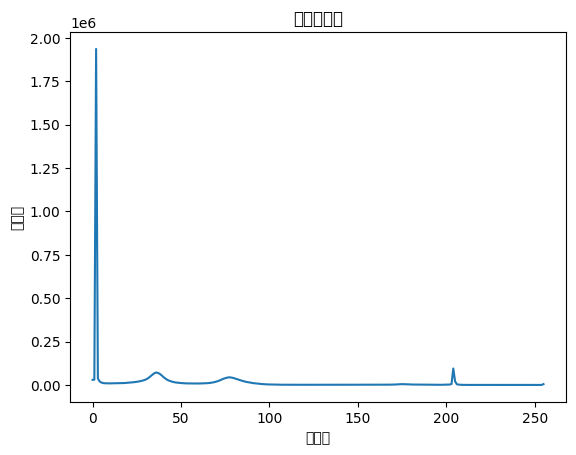

In [25]:
# 统计灰度值
# 方法1：使用numpy的直方图
# hist, bins = np.histogram(image.flatten(), 256, [0, 256])

# 方法2：使用OpenCV的calcHist函数
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

# 打印灰度直方图
for i in range(256):
    print(f"灰度值 {i}: {hist[i]} 像素")

# 可视化灰度直方图（可选）
import matplotlib.pyplot as plt
plt.plot(hist)
plt.title('灰度直方图')
plt.xlabel('灰度值')
plt.ylabel('像素数')
plt.show()

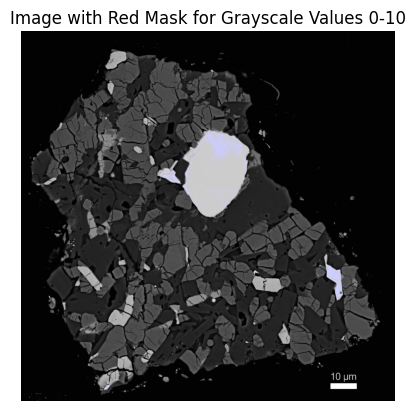

In [26]:
# 创建一个红色半透明掩码
mask = np.zeros_like(gray_image, dtype=np.uint8)
mask[(gray_image >= 205) & (gray_image <= 221)] = 255  # 灰度值在0～10之间的像素设置为255

# 将红色掩码叠加在原图上
result = cv2.addWeighted(image, 1, cv2.merge([mask, np.zeros_like(mask), np.zeros_like(mask)]), 0.5, 0)

# 显示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Image with Red Mask for Grayscale Values 0-10')
plt.axis('off')
plt.show()

In [25]:
# 定义灰度值区间和峰值区间
ranges = {
    'Zr': {'gray': [205, 225], 'peak': [219, 221]},
    'IIm': {'gray': [190, 205], 'peak': [197, 200]},
    'Merr': {'gray': [160, 180], 'peak': [151, 154]},
    'pyx': {'gray': [100, 120], 'peak': [110, 117]},
    'Pl': {'gray': [55, 75], 'peak': [61, 70]},
    'K-glass': {'gray': [30, 50], 'peak': [30, 50]},
}
# ***
# 锆石（Zr）：灰度区间 [205,225]，峰值区间219-221
# 钛铁矿（IIm）:灰度区间[190,205]，峰值区间：197-200
# 白磷钙矿(Merr):灰度区间 [160,180]，峰值区间：151-154
# 辉石（pyx）:灰度区间[100,120]，峰值区间：110-117
# 斜长石（Pl）:灰度区间[55,75]，峰值区间：61-70
# 含钾玻璃（K-glass）: [30,50].峰值区间：[30,50]
# ***

# 初始化存储像素位置的字典
pixel_positions = {key: [] for key in ranges.keys()}

# 遍历每个灰度值区间，找到符合条件的像素位置
for mineral, values in ranges.items():
    lower_gray, upper_gray = values['gray']
    lower_peak, upper_peak = values['peak']
    
    # 使用NumPy进行筛选
    mask = np.where(
        (image >= lower_peak) & (image <= upper_peak)
    )
    
    # 存储像素位置
    pixel_positions[mineral] = list(zip(mask[0], mask[1]))

In [26]:
len(pixel_positions['K-glass'])

2389491

In [27]:
predictor.set_image(image)

In [28]:
positive_samples = []
negative_samples = []
labels = []
current_class = 'K-glass'
positive_num = 500
negative_number = 2
# 从每个矿物的像素位置中随机选择 10 个作为正样本，同时从其他类中随机选择 10 个作为负样本
for mineral, positions in pixel_positions.items():
    if mineral == current_class:
        positive_samples.extend(random.sample(positions, min(positive_num, len(positions))))
        other_minerals = [key for key in pixel_positions.keys() if key != mineral]
        for other_mineral in other_minerals:
            negative_samples.extend(random.sample(pixel_positions[other_mineral], min(negative_number, len(pixel_positions[other_mineral]))))

# 生成对应的标签列表，正样本用标签 1 表示，负样本用标签 0 表示
labels.extend([1] * len(positive_samples))
labels.extend([0] * len(negative_samples))

# 将正负样本和标签列表打包成元组
samples = list(zip(positive_samples + negative_samples, labels))


In [29]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [30]:
input_point = np.array(positive_samples+negative_samples)
input_label = np.array(labels)

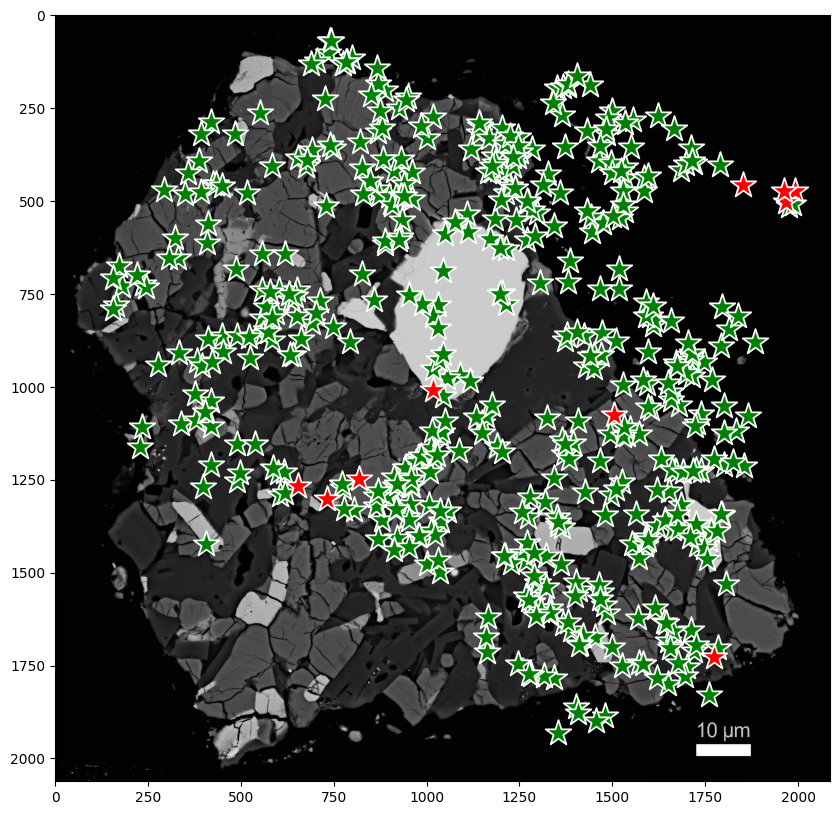

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [287]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    num_multimask_outputs=4,
    use_stability_score=True
)

In [21]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

NameError: name 'scores' is not defined